# Sequence Comparison and Difference Analysis Tutorial (LSOG / dyadic_children)

This tutorial shows how to use **Sequenzo's compare_differences** module with the **LSOG dyadic_children** dataset. You will learn:

1. **Setup** — Load data and build a `SequenceData` object
2. **Position-wise Analysis** — Analyze how group differences evolve across positions using sliding windows
3. **Overall Comparison** — Compare groups using likelihood ratio tests and Bayesian information criterion
4. **Visualization** — Plot group differences across positions
5. **Interpretation** — Understand the statistics and their meaning

The `compare_differences` module provides two main types of analysis:

- **Position-wise Discrepancy Analysis** (`compare_groups_across_positions`): Analyzes how differences between groups evolve along positions using sliding windows.

- **Sequence Comparison Tests** (`compare_groups_overall`, `compute_likelihood_ratio_test`, `compute_bayesian_information_criterion_test`): Performs likelihood ratio tests and Bayesian information criterion tests to compare groups.

All functions return pandas DataFrames or NumPy arrays that you can use for further analysis. The API is designed to be consistent with **TraMineR** where applicable.

## 1. Load LSOG data and build SequenceData

We use the **dyadic_children** dataset (LSOG): state sequences with numeric time columns (ages 15–39) and an ID column `dyadID`. States are coded 1–6.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sequenzo import SequenceData
from sequenzo.datasets import load_dataset
from sequenzo.compare_differences import (
    compare_groups_across_positions,
    plot_group_differences_across_positions,
    print_group_differences_across_positions,
    compare_groups_overall,
    compute_likelihood_ratio_test,
    compute_bayesian_information_criterion_test,
)

# Load dataset
df = load_dataset("dyadic_children")

# Extract time columns (numeric columns)
time_list = [c for c in df.columns if str(c).isdigit()]
time_list = sorted(time_list, key=int)

# Define states (1-indexed, matching TraMineR convention)
states = [1, 2, 3, 4, 5, 6]

# Create SequenceData object
seqdata = SequenceData(
    df,
    time=time_list,
    id_col="dyadID",
    states=states,
)

print(f"Sequences: {seqdata.n_sequences}, time points: {seqdata.n_steps}")
print(f"\nFirst few sequences:")
seqdata.data.head()


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Not provided
Sequences: 60, time points: 25

First few sequences:


,dyadID,sex,15,16,17,18,19,20,21,22,...,30,31,32,33,34,35,36,37,38,39
0,16,1,1,1,1,1,1,3,3,4,...,4,4,4,4,4,4,4,4,4,4
1,19,1,1,1,1,1,1,1,1,1,...,3,3,4,4,4,4,4,4,4,4
2,26,1,1,1,1,1,2,3,3,3,...,6,6,4,4,4,4,4,4,4,4
3,29,0,1,1,1,1,1,1,1,1,...,3,3,3,3,3,3,3,4,4,4
4,31,0,1,1,1,2,3,3,3,3,...,6,6,6,6,6,6,6,6,6,6


## 2. Create grouping variable

For comparing groups, we need a grouping variable. We'll use the `sex` variable from the dataset, or create a simple two-group split for demonstration.

In [2]:
# Option 1: Use sex variable (if available)
if "sex" in df.columns:
    group = df["sex"].values
    print("Using sex variable:")
    print(pd.Series(group).value_counts())
else:
    # Option 2: Create a simple two-group split (first half vs second half)
    group = np.array(['A'] * (len(df) // 2) + ['B'] * (len(df) - len(df) // 2))
    print("Using simple two-group split:")
    print(pd.Series(group).value_counts())

# Show first few group assignments
print(f"\nFirst 10 group assignments: {group[:10]}")

Using sex variable:
1    36
0    24
Name: count, dtype: int64

First 10 group assignments: [1 1 1 0 0 1 1 0 1 1]


## 3. Position-wise Discrepancy Analysis — `compare_groups_across_positions()`

The `compare_groups_across_positions()` function analyzes how differences between groups evolve across positions using sliding windows. At each position t, it computes distances over a time-window and derives the explained discrepancy.

### 3.1 Basic usage with default parameters

In [3]:
# Basic compare_groups_across_positions with cmprange=(0, 1), method='LCS', norm='auto'
result = compare_groups_across_positions(
    seqdata,
    group=group,
    cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False,
    weighted=True,
    squared=False
)

# Print summary
print_group_differences_across_positions(result)

# View statistics
print("\nStatistics (first 10 rows):")
result['stat'].head(10)


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 1 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alway

[notice] A new release of sequenzo is available: 0.1.32 -> 0.1.33
[notice] To update, run: pip install --upgrade sequenzo==0.1.33



[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 12 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alwa

,Pseudo F,Pseudo Fbf,Pseudo R2,Bartlett,Levene
15,NaN,NaN,0.000000,NaN,NaN
16,2.302290,3.572519,0.038179,-97.581690,0.000000e+00
17,2.672478,3.744729,0.044048,20.524884,0.000000e+00
18,6.432727,8.828141,0.099836,16.787313,0.000000e+00
19,8.806689,11.542373,0.131823,10.706281,0.000000e+00
20,4.312821,5.067961,0.069212,2.786802,0.000000e+00
21,2.116044,2.357396,0.035199,0.927567,6.475358e-15
22,2.530174,2.794296,0.041800,0.721641,0.000000e+00
23,3.082275,3.373483,0.050461,0.536251,-1.191844e-14
24,2.897218,3.132178,0.047576,0.327936,0.000000e+00


### 3.2 Understanding the output

The `compare_groups_across_positions()` function returns a dictionary with two components:

- **`stat`**: A DataFrame with statistics (Pseudo F, Pseudo Fbf, Pseudo R2, Bartlett, Levene) for each position
- **`discrepancy`**: A DataFrame with discrepancy values per group and total

In [4]:
# Statistics DataFrame
stat_df = result['stat']
print("Statistics (first 10 rows):")
print(stat_df.head(10))

# Discrepancy DataFrame
discrepancy_df = result['discrepancy']
print("\nDiscrepancy (first 10 rows):")
print(discrepancy_df.head(10))

# Summary statistics
print("\nSummary of Pseudo R2:")
print(stat_df['Pseudo R2'].describe())

Statistics (first 10 rows):
    Pseudo F  Pseudo Fbf  Pseudo R2   Bartlett        Levene
15       NaN         NaN   0.000000        NaN           NaN
16  2.302290    3.572519   0.038179 -97.581690  0.000000e+00
17  2.672478    3.744729   0.044048  20.524884  0.000000e+00
18  6.432727    8.828141   0.099836  16.787313  0.000000e+00
19  8.806689   11.542373   0.131823  10.706281  0.000000e+00
20  4.312821    5.067961   0.069212   2.786802  0.000000e+00
21  2.116044    2.357396   0.035199   0.927567  6.475358e-15
22  2.530174    2.794296   0.041800   0.721641  0.000000e+00
23  3.082275    3.373483   0.050461   0.536251 -1.191844e-14
24  2.897218    3.132178   0.047576   0.327936  0.000000e+00

Discrepancy (first 10 rows):
           0         1     Total
15  0.000000  0.000000  0.000000
16  0.000000  0.050540  0.031528
17  0.019965  0.141590  0.097222
18  0.039931  0.228009  0.169722
19  0.076389  0.295139  0.239167
20  0.173611  0.335648  0.290972
21  0.248264  0.361111  0.327500
22  0.2

### 3.3 Different sliding window ranges

The `cmprange` parameter controls the sliding window size. A larger window provides more stable estimates but less temporal resolution.

In [5]:
# Compare with different window sizes
# cmprange=(0, 1): Compare position t with t+1
result_01 = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# cmprange=(-1, 1): Centered window of length 3
result_centered3 = compare_groups_across_positions(
    seqdata, group=group, cmprange=(-1, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# cmprange=(-2, 2): Centered window of length 5
result_centered5 = compare_groups_across_positions(
    seqdata, group=group, cmprange=(-2, 2),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# Compare Pseudo R2 values
print("Pseudo R2 with cmprange=(0, 1):")
print(result_01['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 with cmprange=(-1, 1):")
print(result_centered3['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 with cmprange=(-2, 2):")
print(result_centered5['stat']['Pseudo R2'].head(5))


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 1 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alway

### 3.4 Different distance methods

You can use different distance methods: LCS (Longest Common Subsequence), OM (Optimal Matching), HAM (Hamming), etc.

In [6]:
# LCS method (default)
result_lcs = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# OM method (requires substitution matrix)
result_om = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'OM', 'norm': 'auto', 'sm': 'TRATE'},
    with_missing=False, weighted=True, squared=False
)

# HAM method
result_ham = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'HAM', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# Compare Pseudo R2
print("Pseudo R2 with LCS:")
print(result_lcs['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 with OM:")
print(result_om['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 with HAM:")
print(result_ham['stat']['Pseudo R2'].head(5))


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 1 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alway

### 3.5 Squared vs non-squared distances

The `squared` parameter controls whether to use squared distances in the analysis.

In [7]:
# Non-squared distances (default)
result_unsquared = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# Squared distances
result_squared = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=True
)

# Compare Pseudo R2
print("Pseudo R2 (non-squared):")
print(result_unsquared['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 (squared):")
print(result_squared['stat']['Pseudo R2'].head(5))


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 1 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alway

### 3.6 Weighted vs unweighted

The `weighted` parameter controls whether to use sequence weights in the analysis.

In [8]:
# Weighted (default)
result_weighted = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=True, squared=False
)

# Unweighted
result_unweighted = compare_groups_across_positions(
    seqdata, group=group, cmprange=(0, 1),
    seqdist_args={'method': 'LCS', 'norm': 'auto'},
    with_missing=False, weighted=False, squared=False
)

# Compare Pseudo R2
print("Pseudo R2 (weighted):")
print(result_weighted['stat']['Pseudo R2'].head(5))

print("\nPseudo R2 (unweighted):")
print(result_unweighted['stat']['Pseudo R2'].head(5))


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are always included by default, consistent with TraMineR.
[>] Processing 60 sequences with 6 unique states.
[>] Identified 1 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.

[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 2
[>] Min/Max sequence length: 2 / 2
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[!] 'with_missing' has been removed and is ignored.
    Missing values are alway

### 3.7 Plotting results — `plot_group_differences_across_positions()`

Visualize how group differences evolve across positions.

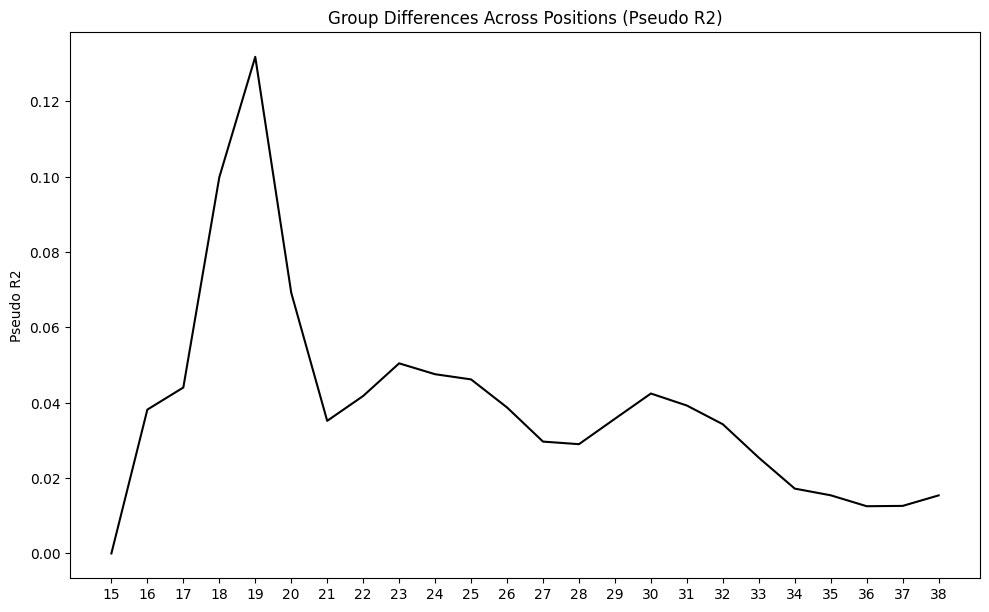

In [9]:
# Plot Pseudo R2
fig1 = plot_group_differences_across_positions(result, stat='Pseudo R2')
plt.title('Group Differences Across Positions (Pseudo R2)')
plt.show()

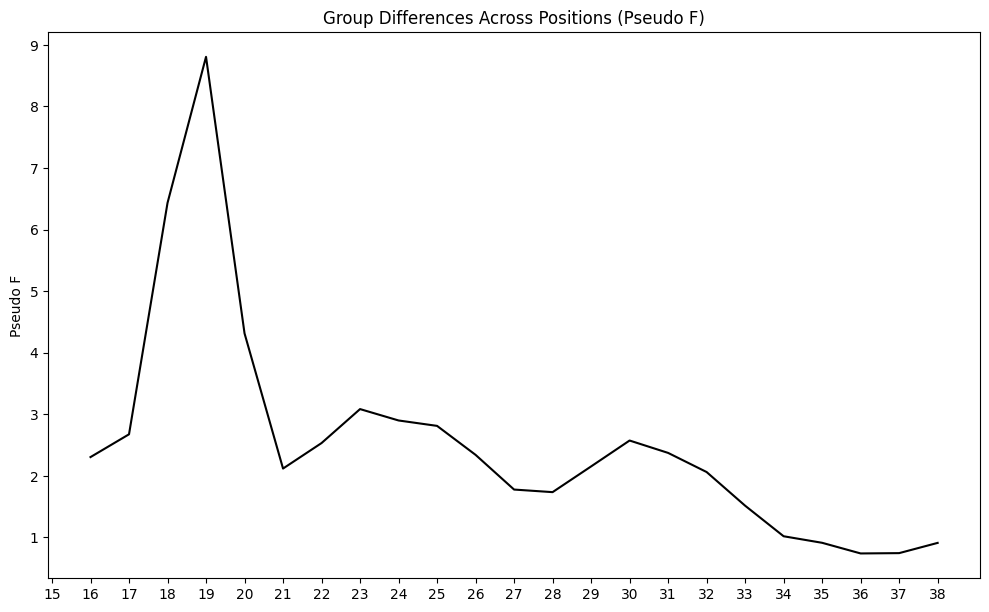

In [10]:
# Plot Pseudo F
fig2 = plot_group_differences_across_positions(result, stat='Pseudo F')
plt.title('Group Differences Across Positions (Pseudo F)')
plt.show()

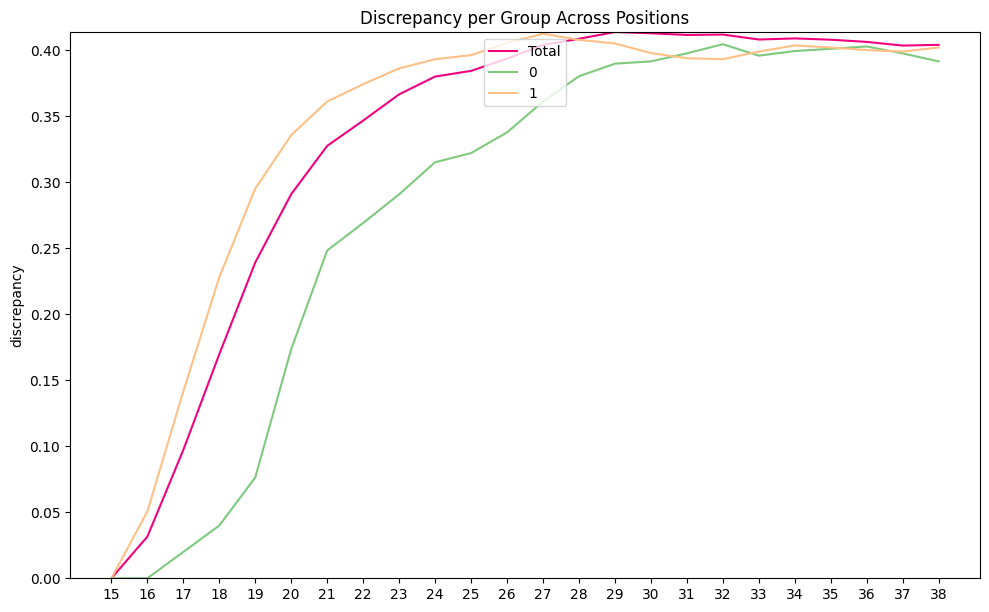

In [11]:
# Plot discrepancy
fig3 = plot_group_differences_across_positions(result, stat='discrepancy')
plt.title('Discrepancy per Group Across Positions')
plt.show()

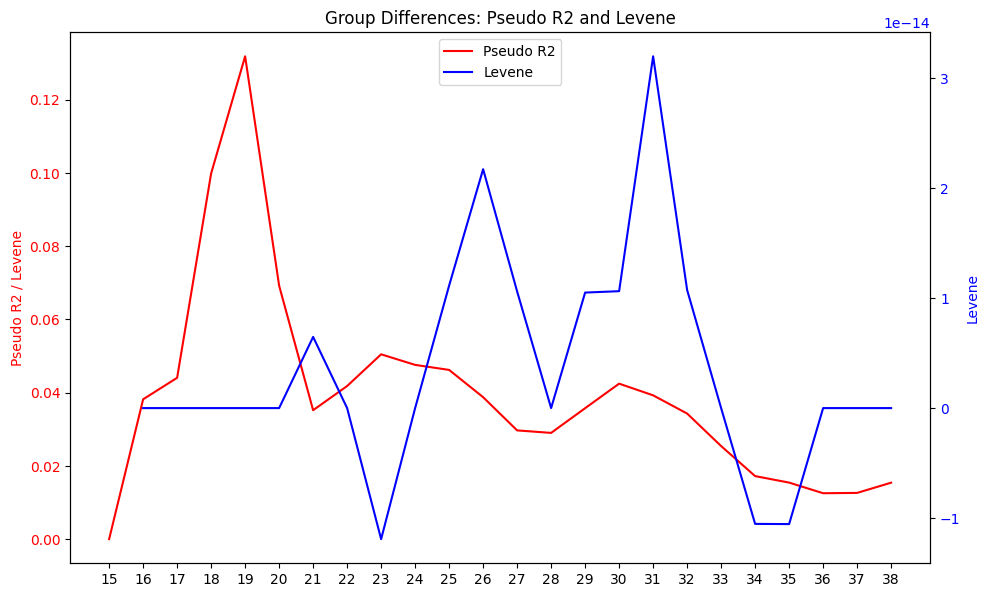

In [12]:
# Plot two statistics on dual y-axes
fig4 = plot_group_differences_across_positions(result, stat=['Pseudo R2', 'Levene'])
plt.title('Group Differences: Pseudo R2 and Levene')
plt.show()

## 4. Overall Sequence Comparison — `compare_groups_overall()`

The `compare_groups_overall()` function compares two groups of sequences using likelihood ratio tests (LRT) and Bayesian Information Criterion (BIC).

### 4.1 Basic usage — all statistics

In [13]:
# Compare groups with all statistics (LRT and BIC)
np.random.seed(36963)  # For reproducibility
compare_result = compare_groups_overall(
    seqdata,
    group=group,
    s=100,           # Bootstrap sample size
    seed=36963,
    stat="all",      # Compute both LRT and BIC
    squared="LRTonly",
    weighted=True,
    method="LCS"
)

# Print results
print("Comparison results (LRT, p-value, Delta BIC, Bayes Factor):")
print(compare_result)

# Convert to DataFrame for better display
result_df = pd.DataFrame(
    compare_result,
    columns=["LRT", "p-value", "Delta BIC", "Bayes Factor"]
)
print("\nFormatted results:")
print(result_df)


[>] SequenceData initialized successfully! Here's a summary:
[>] Number of sequences: 60
[>] Number of time points: 25
[>] Min/Max sequence length: 25 / 25
[>] States: [1, 2, 3, 4, 5, 6]
[>] Labels: ['1', '2', '3', '4', '5', '6']
[>] Weights: Provided (total weight=60.000, mean=1.000, std=0.000)
[>] Processing 60 sequences with 6 unique states.
[>] Identified 51 unique sequences.
[>] Starting Longest Common Subsequence (LCS)...
[>] Computing all pairwise distances...
[>] Computed Successfully.


ValueError: Weights array size mismatch: weights_all_a has 24 elements, but seq_a[i] has 36 rows. m_n[i]=36, mask_a sum=24

### 4.2 Likelihood Ratio Test only — `compute_likelihood_ratio_test()`

In [ ]:
# Compute LRT only
np.random.seed(36963)
lrt_result = compute_likelihood_ratio_test(
    seqdata,
    group=group,
    s=100,
    seed=36963,
    squared="LRTonly",
    weighted=True,
    method="LCS"
)

# Print results
print("LRT results (LRT, p-value):")
print(lrt_result)

# Interpret results
print("\nInterpretation:")
print(f"LRT statistic: {lrt_result[0, 0]:.4f}")
print(f"p-value: {lrt_result[0, 1]:.4f}")
if lrt_result[0, 1] < 0.05:
    print("Groups are significantly different (p < 0.05)")
else:
    print("Groups are not significantly different (p >= 0.05)")

### 4.3 Bayesian Information Criterion only — `compute_bayesian_information_criterion_test()`

In [ ]:
# Compute BIC only
np.random.seed(36963)
bic_result = compute_bayesian_information_criterion_test(
    seqdata,
    group=group,
    s=100,
    seed=36963,
    squared="LRTonly",
    weighted=True,
    method="LCS"
)

# Print results
print("BIC results (Delta BIC, Bayes Factor):")
print(bic_result)

# Interpret results
print("\nInterpretation:")
print(f"Delta BIC: {bic_result[0, 0]:.4f}")
print(f"Bayes Factor: {bic_result[0, 1]:.4f}")
if bic_result[0, 1] > 10:
    print("Strong evidence for group differences (Bayes Factor > 10)")
elif bic_result[0, 1] > 3:
    print("Moderate evidence for group differences (Bayes Factor 3-10)")
elif bic_result[0, 1] > 1:
    print("Weak evidence for group differences (Bayes Factor 1-3)")
else:
    print("No evidence for group differences (Bayes Factor < 1)")

### 4.4 Different distance methods

In [ ]:
# LCS method
np.random.seed(36963)
compare_lcs = compare_groups_overall(
    seqdata, group=group, s=100, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="LCS"
)

# OM method (requires substitution matrix)
np.random.seed(36963)
compare_om = compare_groups_overall(
    seqdata, group=group, s=100, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="OM", sm="TRATE"
)

# HAM method
np.random.seed(36963)
compare_ham = compare_groups_overall(
    seqdata, group=group, s=100, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="HAM"
)

# Compare results
print("LCS method:")
print(compare_lcs)

print("\nOM method:")
print(compare_om)

print("\nHAM method:")
print(compare_ham)

### 4.5 Different sample sizes

The `s` parameter controls bootstrap sampling. Use `s=0` for no sampling (use all sequences).

In [ ]:
# No sampling (s=0) - use all sequences
np.random.seed(36963)
compare_s0 = compare_groups_overall(
    seqdata, group=group, s=0, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="LCS"
)

# Small sample (s=50)
np.random.seed(36963)
compare_s50 = compare_groups_overall(
    seqdata, group=group, s=50, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="LCS"
)

# Larger sample (s=200)
np.random.seed(36963)
compare_s200 = compare_groups_overall(
    seqdata, group=group, s=200, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="LCS"
)

# Compare results
print("s=0 (no sampling):")
print(compare_s0)

print("\ns=50:")
print(compare_s50)

print("\ns=200:")
print(compare_s200)

### 4.6 Weighted vs unweighted

In [ ]:
# Weighted (default)
np.random.seed(36963)
compare_weighted = compare_groups_overall(
    seqdata, group=group, s=100, seed=36963,
    stat="all", squared="LRTonly", weighted=True,
    method="LCS"
)

# Unweighted
np.random.seed(36963)
compare_unweighted = compare_groups_overall(
    seqdata, group=group, s=100, seed=36963,
    stat="all", squared="LRTonly", weighted=False,
    method="LCS"
)

# Compare results
print("Weighted:")
print(compare_weighted)

print("\nUnweighted:")
print(compare_unweighted)

## 5. Interpretation Guide

### 5.1 Position-wise Analysis (`compare_groups_across_positions`)

- **Pseudo R2**: Proportion of discrepancy explained by groups (0-1). Higher values indicate stronger group differences at that position.
- **Pseudo F**: F-statistic for testing group differences. Higher values indicate more significant differences.
- **Bartlett & Levene**: Tests for homogeneity of variances. Significant values suggest unequal variances between groups.

### 5.2 Overall Comparison (`compare_groups_overall`)

- **LRT**: Likelihood ratio test statistic. Higher values indicate more different groups.
- **p-value**: Probability under null hypothesis. Values < 0.05 indicate significant differences.
- **Delta BIC**: BIC difference. Positive values indicate evidence for differences.
- **Bayes Factor**: Strength of evidence for group differences:
  - 1-3: Weak evidence
  - 3-10: Moderate evidence
  - >10: Strong evidence

## 6. Summary: Sequenzo ↔ TraMineR (compare_differences)

| Step | Sequenzo (Python) | TraMineR/TraMineRextras (R) |
|------|------------------|----------------------------|
| Load & state sequence | `load_dataset` + `SequenceData(..., time, id_col, states)` | `read.csv` + `seqdef(..., alphabet, id)` |
| Position-wise analysis | `compare_groups_across_positions(seqdata, group, cmprange, seqdist_args)` | `seqdiff(seqdata, group, cmprange, seqdist.args)` |
| Plot position-wise | `plot_group_differences_across_positions(result, stat)` | `plot.seqdiff(result, stat)` |
| Print position-wise | `print_group_differences_across_positions(result)` | `print.seqdiff(result)` |
| Overall comparison | `compare_groups_overall(seqdata, group, method, s, stat)` | `seqCompare(seqdata, group, method, s, stat)` |
| LRT only | `compute_likelihood_ratio_test(seqdata, group, method, s)` | `seqLRT(seqdata, group, method, s)` |
| BIC only | `compute_bayesian_information_criterion_test(seqdata, group, method, s)` | `seqBIC(seqdata, group, method, s)` |

## References

- Studer, M., Ritschard, G., Gabadinho, A., & Müller, N. S. (2011). Discrepancy analysis of state sequences. *Sociological methods & research*, 40(3), 471-510.

- Liao, T. F., & Fasang, A. E. (2021). Comparing groups of life-course sequences using the Bayesian information criterion and the likelihood-ratio test. *Sociological Methodology*, 51(1), 44-85.

- TraMineR documentation: <http://traminer.unige.ch>